In [1]:
## Alternativas para datasets: 

## https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

## https://archive.ics.uci.edu/ml/datasets/Apartment+for+rent+classified

## https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [2]:
import numpy as np
import pandas as pd
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import time

## Preambulo: construyendo un SOM en Tensorflow

Extraído de: https://rubikscode.net/2021/07/06/implementing-self-organizing-maps-with-python-and-tensorflow/

https://towardsdatascience.com/understanding-self-organising-map-neural-network-with-python-code-7a77f501e985

In [3]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps,max_learning_rate,max_m_dsitance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

In [4]:
data = pd.read_csv('Airlines.csv')

# Creamos variable delay2 para mapear como variable categórica a Delay

#data['delay2'] = data['Delay'].map({0: 'On Time', 1: 'Delayed'})
data

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


In [5]:
x = data[['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']]

x["Airline"] = x["Airline"].astype('category')
x["AirportFrom"] = x["AirportFrom"].astype('category')
x["AirportTo"] = x["AirportTo"].astype('category')

x["Airline_cat"] = x["Airline"].cat.codes
x["AirportFrom_cat"] = x["AirportFrom"].cat.codes
x["AirportTo_cat"] = x["AirportTo"].cat.codes

x = x.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])
x

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_3773/1730750444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Airline"] = x["Airline"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_3773/1730750444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["AirportFrom"] = x["AirportFrom"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_3773/1730750444.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Flight,DayOfWeek,Time,Length,Airline_cat,AirportFrom_cat,AirportTo_cat
0,269,3,15,205,4,253,135
1,1558,3,15,222,14,217,60
2,2400,3,20,165,1,154,80
3,2466,3,20,195,1,253,80
4,108,3,30,202,2,14,252
...,...,...,...,...,...,...,...
539378,178,5,1439,326,4,203,264
539379,398,5,1439,305,8,252,16
539380,609,5,1439,255,8,253,184
539381,78,5,1439,313,13,128,253


In [6]:
x_norm = minmax_scaler(x)
x_norm

array([[0.0343018 , 0.33333333, 0.00349895, ..., 0.23529412, 0.86643836,
        0.46232877],
       [0.19928325, 0.33333333, 0.00349895, ..., 0.82352941, 0.74315068,
        0.20547945],
       [0.30705235, 0.33333333, 0.0069979 , ..., 0.05882353, 0.52739726,
        0.2739726 ],
       ...,
       [0.07781902, 0.66666667, 1.        , ..., 0.47058824, 0.86643836,
        0.63013699],
       [0.00985537, 0.66666667, 1.        , ..., 0.76470588, 0.43835616,
        0.86643836],
       [0.1844362 , 0.66666667, 1.        , ..., 0.82352941, 0.52739726,
        0.73972603]])

In [7]:
y = data['Delay']
y

0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
539382    1
Name: Delay, Length: 539383, dtype: int64

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2, random_state = 23)
x_train.shape[1]

7

In [9]:
num_neurons = 5*np.sqrt(x_train.shape[0])
grid_size = ceil(np.sqrt(num_neurons))
print(grid_size)

58.0


In [10]:
num_rows = 10
num_cols = 10
max_m_dsitance = 1
max_learning_rate = 0.05
max_steps = int(7.5*10e3)

In [11]:
# initialising self-organising map
num_dims = x_train.shape[1] # numnber of dimensions in the input data
np.random.seed(23)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_dsitance)

  t = np.random.randint(0,high=x_train.shape[0]) # random index of traing data
  winner = winning_neuron(x_train, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(x_train[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

In [12]:
# collecting labels

label_data = y_train
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

label_data[100000]

1

In [13]:
#data['Delay'].groupby(data['Delay']).count()
data['Delay'].count()

539383

In [14]:
indexes = [x for x in range(len(label_data))]

In [15]:
# collecting labels

label_data = y_train
indexes = [x for x in range(len(label_data))]
label_data = label_data.reindex(indexes)

map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
  for col in range(num_cols):
    map[row][col] = [] # empty list to store the label

for t in range(x_train.shape[0]):
  if (t+1) % 1000 == 0:
    print("sample data: ", t+1)
  winner = winning_neuron(x_train, t, som, num_rows, num_cols)
  map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

sample data:  1000
sample data:  2000
sample data:  3000
sample data:  4000
sample data:  5000
sample data:  6000
sample data:  7000
sample data:  8000
sample data:  9000
sample data:  10000
sample data:  11000
sample data:  12000
sample data:  13000
sample data:  14000
sample data:  15000
sample data:  16000
sample data:  17000
sample data:  18000
sample data:  19000
sample data:  20000
sample data:  21000
sample data:  22000
sample data:  23000
sample data:  24000
sample data:  25000
sample data:  26000
sample data:  27000
sample data:  28000
sample data:  29000
sample data:  30000
sample data:  31000
sample data:  32000
sample data:  33000
sample data:  34000
sample data:  35000
sample data:  36000
sample data:  37000
sample data:  38000
sample data:  39000
sample data:  40000
sample data:  41000
sample data:  42000
sample data:  43000
sample data:  44000
sample data:  45000
sample data:  46000
sample data:  47000
sample data:  48000
sample data:  49000
sample data:  50000
sample da

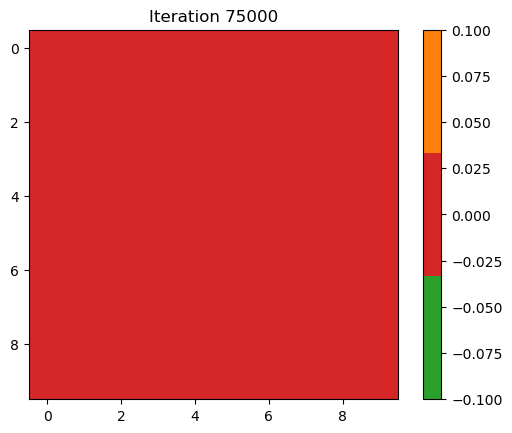

In [16]:
# construct label map

images = []

label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = map[row][col]
    if len(label_list)==0:
      label = 2
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plot = plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

In [17]:
winner_labels = []

for t in range(x_test.shape[0]):
 winner = winning_neuron(x_test, t, som, num_rows, num_cols)
 row = winner[0]
 col = winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(y_test, np.array(winner_labels)))

Accuracy:  0.5549839168682852
